In [44]:
%pip install kaggle
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install polars
%pip install pyarrow
%pip install seaborn
%pip install matplotlib
%pip install xgboost
%pip install psutil

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import os
import shutil

source = r"C:\Users\User\Downloads\kaggle.json"
destination = r"C:\Users\User\.kaggle\kaggle.json"

os.makedirs(os.path.dirname(destination), exist_ok=True)
shutil.move(source, destination)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability


  0%|          | 0.00/3.14G [00:00<?, ?B/s]
  0%|          | 1.00M/3.14G [00:00<45:48, 1.23MB/s]
  0%|          | 2.00M/3.14G [00:01<24:06, 2.33MB/s]
  0%|          | 3.00M/3.14G [00:01<15:35, 3.61MB/s]
  0%|          | 5.00M/3.14G [00:01<08:32, 6.57MB/s]
  0%|          | 8.00M/3.14G [00:01<05:10, 10.9MB/s]
  0%|          | 11.0M/3.14G [00:01<03:49, 14.6MB/s]
  0%|          | 13.0M/3.14G [00:01<03:38, 15.4MB/s]
  0%|          | 16.0M/3.14G [00:01<03:06, 18.0MB/s]
  1%|          | 18.0M/3.14G [00:01<03:08, 17.8MB/s]
  1%|          | 20.0M/3.14G [00:02<04:42, 11.9MB/s]
  1%|          | 22.0M/3.14G [00:02<04:23, 12.7MB/s]
  1%|          | 24.0M/3.14G [00:02<04:26, 12.6MB/s]
  1%|          | 27.0M/3.14G [00:02<04:02, 13.8MB/s]
  1%|          | 30.0M/3.14G [00:02<03:30, 15.9MB/s]
  1%|          | 34.0M/3.14G [00:03<03:01, 18.4MB/s]
  1%|          | 38.0M/3.14G [00:03<02:45, 20.1MB/s]
  1%|▏         | 41.0M/3.14G [00:03<02:34, 21.5MB/s]
  1%|▏         | 45.0M/3.14G [00:03<02:28, 22.4MB/s]
 

In [ ]:
import zipfile

with zipfile.ZipFile('home-credit-credit-risk-model-stability.zip', 'r') as zip_ref:
    zip_ref.extractall('home_credit_data')


## Schema and type sanity

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import gc

In [2]:

# ============================================================================
# MEMORY-OPTIMIZED PARQUET READING PIPELINE
# ============================================================================

import psutil
import gc

def get_memory_gb():
    """Get current process memory in GB"""
    return psutil.Process().memory_info().rss / 1024**3

def log_memory(label):
    """Print memory usage"""
    mem_gb = get_memory_gb()
    print(f"[{label}] Memory: {mem_gb:.2f} GB")

def optimize_dtypes_pandas(df):
    """
    Downcast pandas dtypes to reduce memory:
    - float64 → float32 (50% reduction)
    - int64 → int32/int16/int8 where safe
    - object → category for low-cardinality strings
    """
    for col in df.columns:
        col_type = df[col].dtype
        
        # Downcast integers
        if col_type == 'int64':
            c_min, c_max = df[col].min(), df[col].max()
            if c_min >= -128 and c_max <= 127:
                df[col] = df[col].astype('int8')
            elif c_min >= -32768 and c_max <= 32767:
                df[col] = df[col].astype('int16')
            elif c_min >= -2147483648 and c_max <= 2147483647:
                df[col] = df[col].astype('int32')
        
        # Downcast floats
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        
        # Convert object to category if low cardinality
        elif col_type == 'object':
            num_unique = df[col].nunique()
            num_rows = len(df)
            if num_unique / num_rows < 0.05:  # <5% unique values
                df[col] = df[col].astype('category')
    
    return df

def read_parquet_optimized_polars(parquet_path, columns=None, dtypes_to_downcast=True):
    """
    Read Parquet file using Polars (more memory efficient than pandas).
    
    Args:
        parquet_path: Path to parquet file
        columns: List of columns to read (None = all)
        dtypes_to_downcast: Whether to downcast dtypes
    
    Returns:
        Polars DataFrame
    """
    df = pl.read_parquet(parquet_path, columns=columns)
    
    if dtypes_to_downcast:
        # Downcast in Polars
        for col in df.columns:
            col_type = df[col].dtype
            
            if col_type == pl.Int64:
                c_min, c_max = df[col].min(), df[col].max()
                if c_min is not None and c_max is not None:
                    if c_min >= -128 and c_max <= 127:
                        df = df.with_columns(pl.col(col).cast(pl.Int8))
                    elif c_min >= -32768 and c_max <= 32767:
                        df = df.with_columns(pl.col(col).cast(pl.Int16))
                    elif c_min >= -2147483648 and c_max <= 2147483647:
                        df = df.with_columns(pl.col(col).cast(pl.Int32))
            
            elif col_type == pl.Float64:
                df = df.with_columns(pl.col(col).cast(pl.Float32))
    
    return df

def read_parquet_optimized_pandas(parquet_path, columns=None):
    """
    Read Parquet file using pandas with dtype optimization.
    
    Args:
        parquet_path: Path to parquet file
        columns: List of columns to read (None = all)
    
    Returns:
        Pandas DataFrame with optimized dtypes
    """
    df = pd.read_parquet(parquet_path, columns=columns)
    df = optimize_dtypes_pandas(df)
    return df


In [3]:
# Memory optimization utilities
def reduce_mem_usage(df: pl.DataFrame, verbose: bool = True) -> pl.DataFrame:
    """Reduce memory usage of Polars DataFrame by downcasting numeric types."""
    start_mem = df.estimated_size('mb')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        # Downcast integers
        if col_type == pl.Int64:
            c_min, c_max = df[col].min(), df[col].max()
            if c_min is not None and c_max is not None:
                if c_min >= -128 and c_max <= 127:
                    df = df.with_columns(pl.col(col).cast(pl.Int8))
                elif c_min >= -32768 and c_max <= 32767:
                    df = df.with_columns(pl.col(col).cast(pl.Int16))
                elif c_min >= -2147483648 and c_max <= 2147483647:
                    df = df.with_columns(pl.col(col).cast(pl.Int32))
        
        # Downcast floats
        elif col_type == pl.Float64:
            df = df.with_columns(pl.col(col).cast(pl.Float32))
    
    end_mem = df.estimated_size('mb')
    if verbose:
        print(f'Memory usage: {start_mem:.2f} MB -> {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    
    return df

def log_memory(label: str = ""):
    """Log current memory usage."""
    import psutil
    process = psutil.Process()
    mem_gb = process.memory_info().rss / 1024**3
    print(f'{label} Memory: {mem_gb:.2f} GB')

def cleanup(*dfs):
    """Delete dataframes and run garbage collection."""
    for df in dfs:
        del df
    gc.collect()

In [4]:
def convert_string_to_float(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if col[-1] in ("A", "P"):
            df = df.with_columns(
                pl.col(col).cast(pl.Float64, strict=False).alias(col)
            )
    return df

def parse_date(df: pl.DataFrame) -> pl.DataFrame:
    exprs = []

    # parse date_decision (special column, not ending with D)
    if "date_decision" in df.columns and df.schema["date_decision"] == pl.Utf8:
        exprs.append(
            pl.col("date_decision").str.strptime(pl.Date, strict=False).alias("date_decision")
        )

    # parse all *D columns
    d_cols = [c for c in df.columns if c.endswith("D") and df.schema[c] == pl.Utf8]
    exprs += [pl.col(c).str.strptime(pl.Date, strict=False).alias(c) for c in d_cols]

    return df.with_columns(exprs) if exprs else df



def convert_relative_time(df: pl.DataFrame) -> pl.DataFrame:
    # Only process if date_decision exists
    if "date_decision" not in df.columns:
        # Just drop MONTH if it exists and return
        if "MONTH" in df.columns:
            df = df.drop("MONTH")
        return df
    
    # Get all columns ending with D (excluding date_decision itself)
    d_cols = [c for c in df.columns if c.endswith("D") and c != "date_decision"]
    
    # For each D column, calculate relative time (in years) only where both are not null
    for col in d_cols:
        if col in df.columns:
            # Ensure both columns are Date type, then calculate difference
            df = df.with_columns(
                pl.when(
                    pl.col(col).is_not_null() & pl.col("date_decision").is_not_null()
                ).then(
                    (pl.col(col).cast(pl.Date) - pl.col("date_decision").cast(pl.Date)).dt.total_days() / -365
                ).otherwise(None).alias(col)
            )
    
    # Drop the original date columns if they exist
    cols_to_drop = [c for c in ["date_decision", "MONTH"] if c in df.columns]
    if cols_to_drop:
        df = df.drop(cols_to_drop)
    
    return df


# check consistency of suffixes
def suffix_consistency_report(df: pl.DataFrame, n_check: int = 5):
    problems = []
    for c, dt in zip(df.columns, df.dtypes):
        suf = c[-1]
        if suf == "D" and dt not in (pl.Date, pl.Datetime, pl.Utf8):
            problems.append((c, suf, str(dt), "D should be Utf8 or Date/Datetime"))
        if suf in ("A", "P") and dt == pl.Utf8:
            problems.append((c, suf, str(dt), "A/P often numeric but loaded as string"))
        if suf == "M" and dt not in (pl.Utf8, pl.Categorical):
            problems.append((c, suf, str(dt), "M should usually be string/categorical"))
    return problems

In [5]:
# Load train and test data
train_baseTable = pl.read_parquet("home_credit_data/parquet_files/train/train_base.parquet")
test_baseTable = pl.read_parquet("home_credit_data/parquet_files/test/test_base.parquet")

In [6]:
train_baseTable.head(10)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
5,"""2019-01-02""",201901,0,0
6,"""2019-01-03""",201901,0,0
7,"""2019-01-03""",201901,0,0
8,"""2019-01-03""",201901,0,0


In [7]:
train_baseTable.describe()

statistic,case_id,date_decision,MONTH,WEEK_NUM,target
str,f64,str,f64,f64,f64
"""count""",1.526659e6,"""1526659""",1.526659e6,1.526659e6,1.526659e6
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",1.2861e6,null,201936.287982,40.769036,0.031437
"""std""",718946.592285,null,44.735975,23.797981,0.174496
"""min""",0.0,"""2019-01-01""",201901.0,0.0,0.0
"""25%""",766198.0,null,201906.0,23.0,0.0
"""50%""",1.357358e6,null,201910.0,40.0,0.0
"""75%""",1.739023e6,null,202001.0,55.0,0.0
"""max""",2.703454e6,"""2020-10-05""",202010.0,91.0,1.0


In [8]:
test_baseTable.head(10)

case_id,date_decision,MONTH,WEEK_NUM
i64,str,i64,i64
57543,"""2021-05-14""",202201,100
57549,"""2022-01-17""",202201,100
57551,"""2020-11-27""",202201,100
57552,"""2020-11-27""",202201,100
57569,"""2021-12-20""",202201,100
57630,"""2021-03-16""",202201,100
57631,"""2022-06-04""",202201,100
57632,"""2022-02-05""",202201,100
57633,"""2022-01-25""",202201,100


In [9]:
test_baseTable.describe()

statistic,case_id,date_decision,MONTH,WEEK_NUM
str,f64,str,f64,f64
"""count""",10.0,"""10""",10.0,10.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",57592.4,null,202201.0,100.0
"""std""",42.253731,null,0.0,0.0
"""min""",57543.0,"""2020-11-27""",202201.0,100.0
"""25%""",57551.0,null,202201.0,100.0
"""50%""",57630.0,null,202201.0,100.0
"""75%""",57632.0,null,202201.0,100.0
"""max""",57634.0,"""2022-06-04""",202201.0,100.0


## Count missing values for high-missing numerical columns

In [10]:
def count_missing_values_row(df: pl.DataFrame) -> pl.DataFrame:
    # Missing count per row
    df = df.with_columns(
        pl.sum_horizontal(pl.all().is_null()).alias("missing_count")
    )

    # Set null threshold to be 0.3
    high_missing_col = [c for c in df.columns
                        if c[-1] in ["P", "A", "L"]
                        and df.select(pl.col(c).null_count()).item() / df.height > 0.3
                        ]
    
    df = df.with_columns(
        pl.col(high_missing_col).is_null().cast(pl.Int8).suffix("_is_null")
    )

## Ratio and relative features


In [11]:
def ratio_features(df: pl.DataFrame, feature1: str, feature2: str) -> pl.DataFrame:
    ratio_col = f"{feature1}_{feature2}"

    return df.with_columns(
        pl.when(
            pl.col(feature1).is_not_null() &
            pl.col(feature2).is_not_null() &
            pl.col(feature2) != 0
        )
        .then(pl.col(feature1) / pl.col(feature2))
        .otherwise(None)
        .alias(ratio_col)
    )


# for skewed features
def log_ratio_features(df: pl.DataFrame, feature1: str, feature2: str) -> pl.DataFrame:
    ratio_col = f"{feature1}_{feature2}"

    return df.with_columns(
        pl.when(
            pl.col(feature1).is_not_null() &
            pl.col(feature2).is_not_null() &
            pl.col(feature2) != 0
        )
        .then(pl.col(feature1) / pl.col(feature2))
        .otherwise(None)
        .alias(ratio_col)
    )

## Scaling 

In [12]:
# RobustScaler for skewed features
# QuantileTransformer for extreme tails

## Data visualisation

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

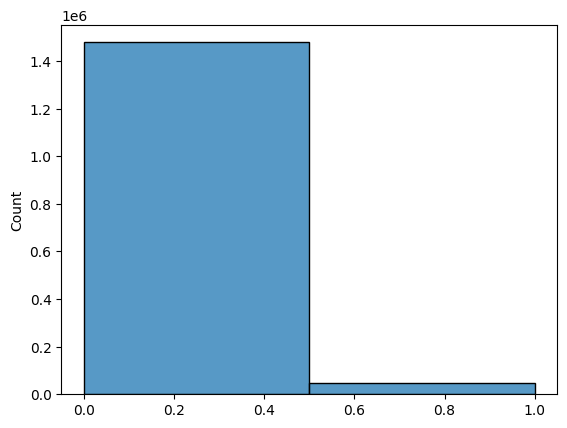

In [13]:
import seaborn as sns
sns.histplot(train_baseTable["target"], bins=2)

<p>We can see that accuracy is not appropriate here because of the highly imbalanced classes. If the model always predicts non-default classes it will always have 0.95 accuracy which is wrong, so AUC must be used in this case</p>

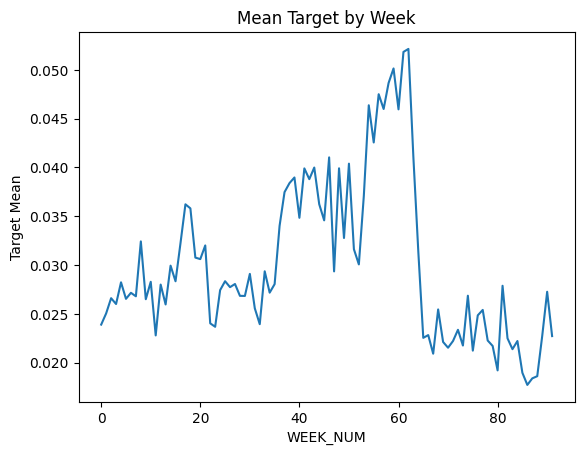

In [14]:
# Class imbalance and time drift
import matplotlib.pyplot as plt
pdf = (
    train_baseTable
    .group_by("WEEK_NUM")
    .agg(pl.col("target").mean().alias("target_mean"))
    .sort("WEEK_NUM")
    .to_pandas()
)
plt.plot(pdf["WEEK_NUM"], pdf["target_mean"])
plt.xlabel("WEEK_NUM")
plt.ylabel("Target Mean")
plt.title("Mean Target by Week")
plt.show()

<p>Early period: stable and low</p>
<p>Middle period: strong increase</p>
<p>Sudden drop somewhere in the middle</p>
<p>End: Stays low</p>
<p>Suggesting that there is a distribution shift</p>

In [15]:
def plot_missing_features(df):
    missing_rate = df.isnull().mean().sort_values(ascending=False)

    missing_rate.head(20).plot.barh()

## Centralised table paths 

In [16]:
from pathlib import Path

DATA_DIR = Path("home_credit_data/parquet_files/train")

TABLES = {
    "base": DATA_DIR / "train_base.parquet",
    "static_0_0": DATA_DIR / "train_static_0_0.parquet",
    "static_0_1": DATA_DIR / "train_static_0_1.parquet",
    "static_cb_0": DATA_DIR / "train_static_cb_0.parquet",
    "person_1": DATA_DIR / "train_person_1.parquet",
    "person_2": DATA_DIR / "train_person_2.parquet",
    "applprev_1_0": DATA_DIR / "train_applprev_1_0.parquet",
    "applprev_1_1": DATA_DIR / "train_applprev_1_1.parquet",
    "applprev_2": DATA_DIR / "train_applprev_2.parquet",
    "credit_bureau_a_1_0": DATA_DIR / "train_credit_bureau_a_1_0.parquet",
    "credit_bureau_a_1_1": DATA_DIR / "train_credit_bureau_a_1_1.parquet",
    "credit_bureau_a_1_2": DATA_DIR / "train_credit_bureau_a_1_2.parquet",
    "credit_bureau_a_1_3": DATA_DIR / "train_credit_bureau_a_1_3.parquet",
    "credit_bureau_a_2_0": DATA_DIR / "train_credit_bureau_a_2_0.parquet",
    "credit_bureau_a_2_1": DATA_DIR / "train_credit_bureau_a_2_1.parquet",
    "credit_bureau_a_2_2": DATA_DIR / "train_credit_bureau_a_2_2.parquet",
    "credit_bureau_a_2_3": DATA_DIR / "train_credit_bureau_a_2_3.parquet",
    "credit_bureau_a_2_4": DATA_DIR / "train_credit_bureau_a_2_4.parquet",
    "credit_bureau_a_2_5": DATA_DIR / "train_credit_bureau_a_2_5.parquet",
    "credit_bureau_a_2_6": DATA_DIR / "train_credit_bureau_a_2_6.parquet",
    "credit_bureau_a_2_7": DATA_DIR / "train_credit_bureau_a_2_7.parquet",
    "credit_bureau_a_2_8": DATA_DIR / "train_credit_bureau_a_2_8.parquet",
    "credit_bureau_a_2_9": DATA_DIR / "train_credit_bureau_a_2_9.parquet",
    "credit_bureau_a_2_10": DATA_DIR / "train_credit_bureau_a_2_10.parquet",
    "credit_bureau_b_1": DATA_DIR / "train_credit_bureau_b_1.parquet",
    "credit_bureau_b_2": DATA_DIR / "train_credit_bureau_b_2.parquet",
    "debitcard_1": DATA_DIR / "train_debitcard_1.parquet",
    "deposit_1": DATA_DIR / "train_deposit_1.parquet",
    "other_1": DATA_DIR / "train_other_1.parquet",
    "tax_registry_a_1": DATA_DIR / "train_tax_registry_a_1.parquet",
    "tax_registry_b_1": DATA_DIR / "train_tax_registry_b_1.parquet",
    "tax_registry_c_1": DATA_DIR / "train_tax_registry_c_1.parquet",
}

## Check depth profiling

In [17]:
def table_schema(path):
    return pl.read_parquet(path, n_rows=0).schema

def depth_stats(path):
    df = pl.read_parquet(path).select("case_id")

    return (
        df.group_by("case_id")
        .count()
        .select(
            pl.col("count").mean().alias("avg_rows_per_case"),
            pl.col("count").max().alias("max_rows_per_case"),
            pl.col("count").median().alias("median_rows_per_case")
        )
        )

schema_map = {name: table_schema(path) for name, path in TABLES.items()}
depth_map = {name: depth_stats(path) for name, path in TABLES.items()}

schema_map["base"], depth_map["base"]

C:\Users\User\AppData\Local\Temp\ipykernel_25440\2338636688.py:9: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


C:\Users\User\AppData\Local\Temp\ipykernel_25440\2338636688.py:9: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


(Schema([('case_id', Int64),
         ('date_decision', String),
         ('MONTH', Int64),
         ('WEEK_NUM', Int64),
         ('target', Int64)]),
 shape: (1, 3)
 ┌───────────────────┬───────────────────┬──────────────────────┐
 │ avg_rows_per_case ┆ max_rows_per_case ┆ median_rows_per_case │
 │ ---               ┆ ---               ┆ ---                  │
 │ f64               ┆ u32               ┆ f64                  │
 ╞═══════════════════╪═══════════════════╪══════════════════════╡
 │ 1.0               ┆ 1                 ┆ 1.0                  │
 └───────────────────┴───────────────────┴──────────────────────┘)

In [18]:
# List out tables that can be safely joined/ aggregated/ dangerous to join

def categorize_tables(depth_map, dangerous_max_threshold=100, dangerous_avg_threshold=20):
    rows = []
    for name, stats_df in depth_map.items():
        avg_rows = float(stats_df["avg_rows_per_case"][0])
        med_rows = float(stats_df["median_rows_per_case"][0])
        max_rows = int(stats_df["max_rows_per_case"][0])

        # Categorization rules
        if max_rows == 1:
            category = "SAFE_JOIN"
        elif (max_rows >= dangerous_max_threshold) or (avg_rows >= dangerous_avg_threshold):
            category = "DANGEROUS"
        else:
            category = "MUST_AGG"

        rows.append({
            "table": name,
            "avg_rows_per_case": avg_rows,
            "median_rows_per_case": med_rows,
            "max_rows_per_case": max_rows,
            "category": category
        })

    summary = pl.DataFrame(rows).sort(["category", "max_rows_per_case"], descending=[False, True])
    return summary

summary = categorize_tables(depth_map, dangerous_max_threshold=100, dangerous_avg_threshold=20)
summary
 

table,avg_rows_per_case,median_rows_per_case,max_rows_per_case,category
str,f64,f64,i64,str
"""credit_bureau_a_2_6""",169.5939,132.0,9404,"""DANGEROUS"""
"""credit_bureau_a_2_7""",178.799405,132.0,7859,"""DANGEROUS"""
"""credit_bureau_a_2_5""",142.935178,96.0,5986,"""DANGEROUS"""
"""credit_bureau_a_2_3""",139.453298,96.0,4257,"""DANGEROUS"""
"""credit_bureau_a_2_2""",114.154068,72.0,4209,"""DANGEROUS"""
…,…,…,…,…
"""static_0_0""",1.0,1.0,1,"""SAFE_JOIN"""
"""base""",1.0,1.0,1,"""SAFE_JOIN"""
"""other_1""",1.0,1.0,1,"""SAFE_JOIN"""


In [19]:
safe_tables = summary.filter(pl.col("category") == "SAFE_JOIN")["table"].to_list()
must_agg_tables = summary.filter(pl.col("category") == "MUST_AGG")["table"].to_list()
dangerous_tables = summary.filter(pl.col("category") == "DANGEROUS")["table"].to_list()

print("SAFE to join (1:1):", safe_tables)
print("\nMUST aggregate (1:many):", must_agg_tables)
print("\nDANGEROUS (very high depth):", dangerous_tables)


SAFE to join (1:1): ['static_0_0', 'base', 'other_1', 'static_cb_0', 'static_0_1']

MUST aggregate (1:many): ['tax_registry_a_1', 'applprev_2', 'debitcard_1', 'deposit_1', 'person_2', 'credit_bureau_b_1', 'applprev_1_1', 'applprev_1_0', 'person_1']

DANGEROUS (very high depth): ['credit_bureau_a_2_6', 'credit_bureau_a_2_7', 'credit_bureau_a_2_5', 'credit_bureau_a_2_3', 'credit_bureau_a_2_2', 'credit_bureau_a_2_4', 'credit_bureau_a_2_9', 'credit_bureau_a_2_8', 'credit_bureau_a_2_1', 'credit_bureau_a_2_10', 'credit_bureau_a_2_0', 'credit_bureau_a_1_2', 'credit_bureau_b_2', 'credit_bureau_a_1_0', 'credit_bureau_a_1_1', 'credit_bureau_a_1_3', 'tax_registry_c_1', 'tax_registry_b_1']


In [20]:
def missingness_profile(path, top_n=20):
    df = pl.read_parquet(path)
    return (
        df.select([
            (pl.col(c).null_count() / pl.len()).alias(c)
            for c in df.columns
        ])
        .transpose(include_header=True)
        .rename({"column": "feature", "column_0": "missing_rate"})
        .sort("missing_rate", descending=True)
        .head(top_n)
    )
missingness_profile(TABLES["base"])


feature,missing_rate
str,f64
"""case_id""",0.0
"""date_decision""",0.0
"""MONTH""",0.0
"""WEEK_NUM""",0.0
"""target""",0.0


C:\Users\User\AppData\Local\Temp\ipykernel_25440\1344340580.py:3: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  counts = df.group_by("case_id").count().to_pandas()


C:\Users\User\AppData\Local\Temp\ipykernel_25440\1344340580.py:3: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  counts = df.group_by("case_id").count().to_pandas()


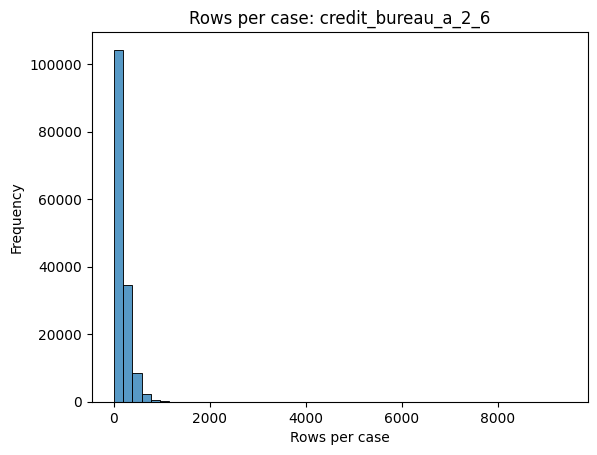

In [21]:
def row_count_distribution(path, title):
    df = pl.read_parquet(path).select("case_id")
    counts = df.group_by("case_id").count().to_pandas()
    sns.histplot(counts["count"], bins=50)
    plt.title(title)
    plt.xlabel("Rows per case")
    plt.ylabel("Frequency")
    plt.show()

row_count_distribution(TABLES["credit_bureau_a_2_6"], "Rows per case: credit_bureau_a_2_6")


In [22]:
# Split columns into numerical and categorical type
def split_cols(schema):
    num, cat = [], []
    for col, dtype in schema.items():
        if col=="case_id":
            continue
        if dtype in (pl.Int64, pl.Int32, pl.Float64, pl.Float32):
            num.append(col)
        else:
            cat.append(col)
    return num, cat

# aggregate to one records, excluded sum because maybe misleading for ratio columns
def agg_to_case(path, schema):
    num_cols, cat_cols = split_cols(schema)

    df = pl.scan_csv(path)
    aggs = []
    for c in num_cols:
        aggs +=[
            pl.col(c).min().alias(f"{c}_min"),
            pl.col(c).max().alias(f"{c}_max"),
            pl.col(c).mean().alias(f"{c}_mean")                        
        ]

    for c in cat_cols:
        aggs += [
            pl.col(c).n_unique().alias(f"{c}_nunique")
        ]
    aggs += [pl.count().alias("row_count")]
    return df.group_by("case_id").agg(aggs).collect()


def agg_person_split(df: pl.LazyFrame, numeric_cols: list[str], cat_cols: list[str]) -> pl.LazyFrame:
    # Applicant rows
    app = df.filter(pl.col("num_group1") == 0)
    # Other related persons
    rel = df.filter(pl.col("num_group1") != 0)

    def make_aggs(prefix: str):
        aggs = []
        for c in numeric_cols:
            aggs += [
                pl.col(c).min().alias(f"{prefix}{c}_min"),
                pl.col(c).max().alias(f"{prefix}{c}_max"),
                pl.col(c).mean().alias(f"{prefix}{c}_mean"),
            ]
        for c in cat_cols:
            aggs += [
                pl.col(c).n_unique().alias(f"{prefix}{c}_nunique"),
            ]
        aggs += [pl.count().alias(f"{prefix}row_count")]
        return aggs

    app_agg = app.group_by("case_id").agg(make_aggs("app_"))
    rel_agg = rel.group_by("case_id").agg(make_aggs("rel_"))

    # Join the two aggregated tables on case_id
    return app_agg.join(rel_agg, on="case_id", how="outer")


# Aggregate with time windows
def agg_with_time_windows(
    df: pl.LazyFrame,
    time_col: str,           
    base_dates: pl.DataFrame,  # case_id + date_decision
    numeric_cols: list[str],
    windows_years=(1, 3, 5),
):
    # Join base dates into the depth table
    df = df.join(base_dates.lazy(), on="case_id", how="left")

    # Parse date if needed then compute age in years (positive = past)
    df = df.with_columns(
        pl.col(time_col).str.strptime(pl.Date, strict=False).alias(time_col)
    ).with_columns(
        ((pl.col("date_decision") - pl.col(time_col)).dt.total_days() / 365.0).alias("age_years")
    )

    aggs_all = []
    # Overall (no window)
    for c in numeric_cols:
        aggs_all += [
            pl.col(c).max().alias(f"{c}_max_all"),
            pl.col(c).mean().alias(f"{c}_mean_all"),
        ]
    aggs_all += [pl.count().alias("row_count_all")]

    # Windowed
    for w in windows_years:
        in_win = pl.col("age_years").is_not_null() & (pl.col("age_years") <= w) & (pl.col("age_years") >= 0)
        for c in numeric_cols:
            aggs_all += [
                pl.col(c).filter(in_win).max().alias(f"{c}_max_le{w}y"),
                pl.col(c).filter(in_win).mean().alias(f"{c}_mean_le{w}y"),
            ]
        aggs_all += [pl.count().filter(in_win).alias(f"row_count_le{w}y")]

    return df.group_by("case_id").agg(aggs_all)

In [23]:
# Memory-optimized merge pipeline
log_memory('Before person_1 aggregation:')

# Aggregate person_1
schema = schema_map["person_1"]
numeric_cols, cat_cols = split_cols(schema)

df = pl.scan_parquet(TABLES["person_1"])
person_1_agg = agg_person_split(df, numeric_cols, cat_cols).collect()
person_1_agg = reduce_mem_usage(person_1_agg)
log_memory('After person_1 aggregation:')

# Load and optimize static tables
static_0_0 = reduce_mem_usage(pl.read_parquet(TABLES["static_0_0"]))
static_0_1 = reduce_mem_usage(pl.read_parquet(TABLES["static_0_1"]))
static_cb_0 = reduce_mem_usage(pl.read_parquet(TABLES["static_cb_0"]))
other_1 = reduce_mem_usage(pl.read_parquet(TABLES["other_1"]))

log_memory('After loading static tables:')

# Sequential merge with memory reduction
merged = train_baseTable

merged = merged.join(static_0_0, on="case_id", how="left")
gc.collect()

merged = merged.join(static_0_1, on="case_id", how="left")
gc.collect()

merged = merged.join(static_cb_0, on="case_id", how="left")
gc.collect()

merged = merged.join(other_1, on="case_id", how="left")
gc.collect()

merged = merged.join(person_1_agg, on="case_id", how="left")
gc.collect()

merged = reduce_mem_usage(merged)
log_memory('After train merge:')

# Test merge pipeline
TEST_DIR = Path("home_credit_data/parquet_files/test")

test_static_0_0 = reduce_mem_usage(pl.read_parquet(TEST_DIR / "test_static_0_0.parquet"))
test_static_0_1 = reduce_mem_usage(pl.read_parquet(TEST_DIR / "test_static_0_1.parquet"))
test_static_cb_0 = reduce_mem_usage(pl.read_parquet(TEST_DIR / "test_static_cb_0.parquet"))
test_other_1 = reduce_mem_usage(pl.read_parquet(TEST_DIR / "test_other_1.parquet"))

test_person_1 = pl.scan_parquet(TEST_DIR / "test_person_1.parquet")
test_person_1_agg = agg_person_split(test_person_1, numeric_cols, cat_cols).collect()
test_person_1_agg = reduce_mem_usage(test_person_1_agg)

log_memory('After loading test tables:')

# Sequential test merge
test_merged = test_baseTable

test_merged = test_merged.join(test_static_0_0, on="case_id", how="left")
gc.collect()

test_merged = test_merged.join(test_static_0_1, on="case_id", how="left")
gc.collect()

test_merged = test_merged.join(test_static_cb_0, on="case_id", how="left")
gc.collect()

test_merged = test_merged.join(test_other_1, on="case_id", how="left")
gc.collect()

test_merged = test_merged.join(test_person_1_agg, on="case_id", how="left")
gc.collect()

test_merged = reduce_mem_usage(test_merged)
log_memory('After test merge:')

print(f'Train shape: {merged.shape}, Test shape: {test_merged.shape}')

Before person_1 aggregation: Memory: 6.69 GB


C:\Users\User\AppData\Local\Temp\ipykernel_25440\1321564150.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  aggs += [pl.count().alias(f"{prefix}row_count")]
C:\Users\User\AppData\Local\Temp\ipykernel_25440\1321564150.py:59: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  return app_agg.join(rel_agg, on="case_id", how="outer")


Before person_1 aggregation: Memory: 6.69 GB


C:\Users\User\AppData\Local\Temp\ipykernel_25440\1321564150.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  aggs += [pl.count().alias(f"{prefix}row_count")]
C:\Users\User\AppData\Local\Temp\ipykernel_25440\1321564150.py:59: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  return app_agg.join(rel_agg, on="case_id", how="outer")


Memory usage: 813.32 MB -> 574.55 MB (29.4% reduction)
After person_1 aggregation: Memory: 7.10 GB
Memory usage: 1145.05 MB -> 651.10 MB (43.1% reduction)
Memory usage: 600.82 MB -> 343.50 MB (42.8% reduction)
Memory usage: 532.22 MB -> 320.44 MB (39.8% reduction)
Memory usage: 2.73 MB -> 1.22 MB (55.4% reduction)
After loading static tables: Memory: 7.51 GB
Memory usage: 2746.58 MB -> 2714.55 MB (1.2% reduction)
After train merge: Memory: 6.77 GB
Memory usage: 0.01 MB -> 0.01 MB (42.7% reduction)
Memory usage: 0.01 MB -> 0.01 MB (42.5% reduction)
Memory usage: 0.00 MB -> 0.00 MB (41.0% reduction)
Memory usage: 0.00 MB -> 0.00 MB (55.4% reduction)
Memory usage: 0.00 MB -> 0.00 MB (29.2% reduction)
After loading test tables: Memory: 6.57 GB
Memory usage: 0.02 MB -> 0.02 MB (0.8% reduction)
After test merge: Memory: 6.54 GB
Train shape: (1526659, 496), Test shape: (10, 495)


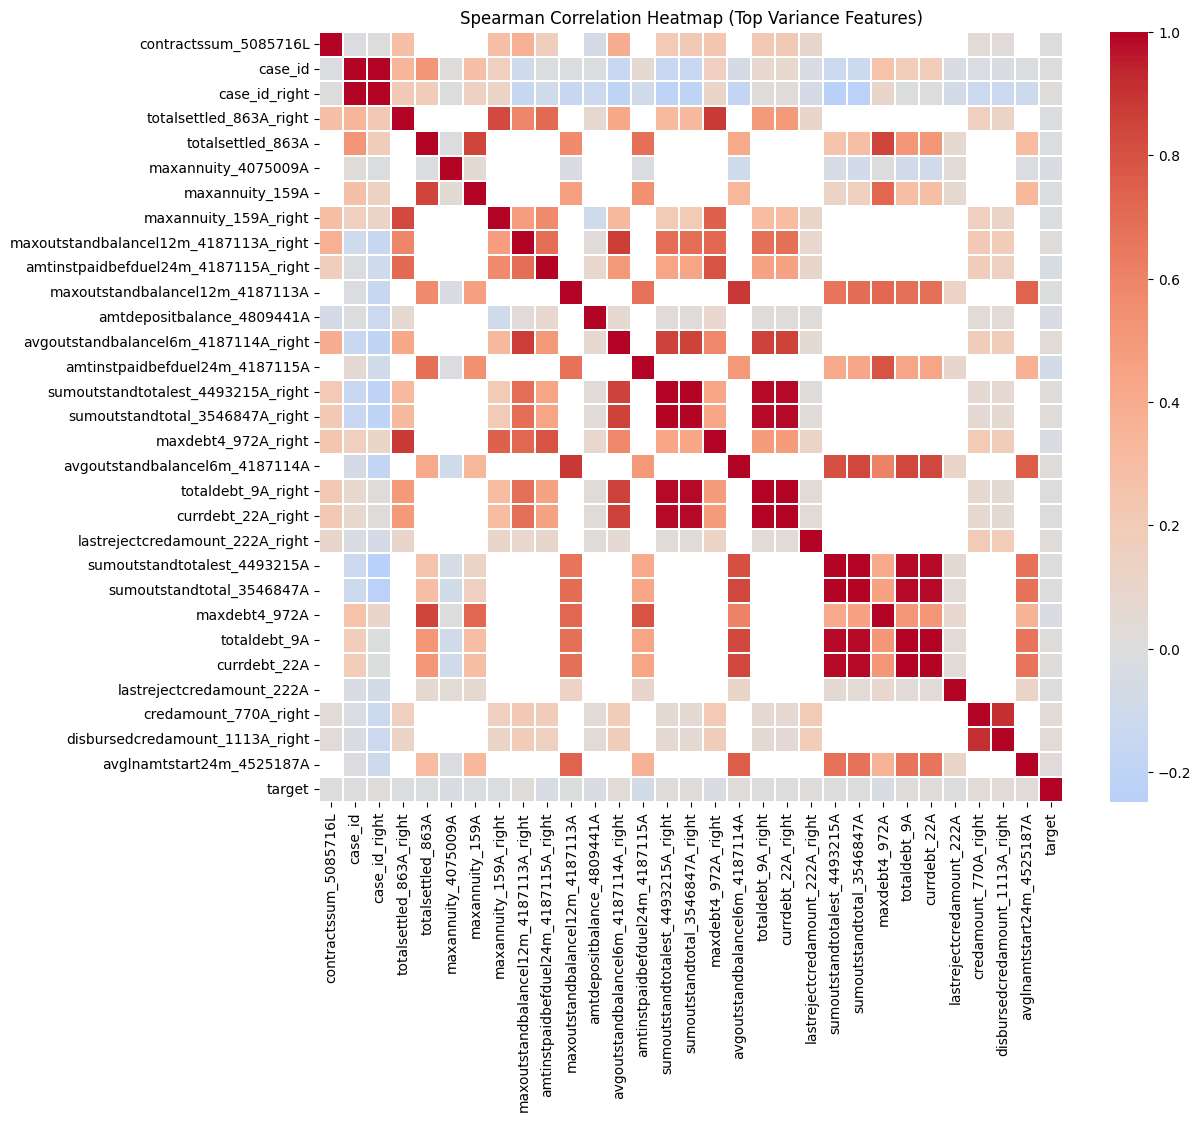

In [24]:
# Select numeric columns only
num_cols = [c for c in merged.columns if merged[c].dtype in (pl.Int64, pl.Int32, pl.Float64, pl.Float32) and c!="target"]
# Sample for plotting
pdf = merged.select(num_cols + ["target"]).sample(n=20000, seed=42).to_pandas()
# Reduce to top variance features to keep heatmap readable
variances = pdf[num_cols].var().sort_values(ascending=False)
top_cols = variances.head(30).index.tolist()

corr = pdf[top_cols + ["target"]].corr(method="spearman")

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.3)
plt.title("Spearman Correlation Heatmap (Top Variance Features)")
plt.show()


## Spearman correlation heatmap
<p>Red: features are highly correlated</p>
<p>White: features are not correlated at all</p>

** need to drop case_id column

** Feature Engineering: Prune feature selections

## Plot features vs target

In [25]:
# Apply typing pipeline with memory optimization
log_memory('Before typing pipeline:')

train_baseTable_typed = parse_date(convert_string_to_float(train_baseTable))
train_baseTable_typed = convert_relative_time(train_baseTable_typed)
train_baseTable_typed = reduce_mem_usage(train_baseTable_typed)

test_baseTable_typed = parse_date(convert_string_to_float(test_baseTable))
test_baseTable_typed = convert_relative_time(test_baseTable_typed)
test_baseTable_typed = reduce_mem_usage(test_baseTable_typed)

merged_typed = parse_date(convert_string_to_float(merged))
merged_typed = convert_relative_time(merged_typed)
merged_typed = reduce_mem_usage(merged_typed)
gc.collect()

test_merged_typed = parse_date(convert_string_to_float(test_merged))
test_merged_typed = convert_relative_time(test_merged_typed)
test_merged_typed = reduce_mem_usage(test_merged_typed)
gc.collect()

log_memory('After typing pipeline:')

# Suffix consistency check (post-typing/parsing)
suffix_consistency_report(merged_typed)[:10]

Before typing pipeline: Memory: 6.62 GB
Memory usage: 34.94 MB -> 8.74 MB (75.0% reduction)
Memory usage: 0.00 MB -> 0.00 MB (68.8% reduction)
Memory usage: 3246.31 MB -> 2745.47 MB (15.4% reduction)
Memory usage: 0.02 MB -> 0.02 MB (15.3% reduction)
After typing pipeline: Memory: 7.29 GB


Before typing pipeline: Memory: 6.62 GB
Memory usage: 34.94 MB -> 8.74 MB (75.0% reduction)
Memory usage: 0.00 MB -> 0.00 MB (68.8% reduction)
Memory usage: 3246.31 MB -> 2745.47 MB (15.4% reduction)
Memory usage: 0.02 MB -> 0.02 MB (15.3% reduction)
After typing pipeline: Memory: 7.29 GB


[('WEEK_NUM', 'M', 'Int8', 'M should usually be string/categorical'),
 ('datefirstoffer_1144D', 'D', 'Float32', 'D should be Utf8 or Date/Datetime'),
 ('datelastinstal40dpd_247D',
  'D',
  'Float32',
  'D should be Utf8 or Date/Datetime'),
 ('datelastunpaid_3546854D',
  'D',
  'Float32',
  'D should be Utf8 or Date/Datetime'),
 ('dtlastpmtallstes_4499206D',
  'D',
  'Float32',
  'D should be Utf8 or Date/Datetime'),
 ('firstclxcampaign_1125D',
  'D',
  'Float32',
  'D should be Utf8 or Date/Datetime'),
 ('firstdatedue_489D', 'D', 'Float32', 'D should be Utf8 or Date/Datetime'),
 ('lastactivateddate_801D',
  'D',
  'Float32',
  'D should be Utf8 or Date/Datetime'),
 ('lastapplicationdate_877D',
  'D',
  'Float32',
  'D should be Utf8 or Date/Datetime'),
 ('lastapprdate_640D', 'D', 'Float32', 'D should be Utf8 or Date/Datetime')]

## Robust feature-vs-target plotting (filters invalid features)
This pipeline selects numeric features, filters out high-missing/low-variance columns, then plots up to 15 valid features. It prevents empty plots by skipping features with too few non-null rows or constant values.

Selected features: ['case_id', 'case_id_right', 'totalsettled_863A_right', 'totalsettled_863A', 'maxannuity_159A', 'amtinstpaidbefduel24m_4187115A', 'totaldebt_9A_right', 'currdebt_22A_right', 'sumoutstandtotal_3546847A', 'maxdebt4_972A', 'totaldebt_9A', 'currdebt_22A', 'lastrejectcredamount_222A', 'credamount_770A_right', 'disbursedcredamount_1113A_right']


Selected features: ['case_id', 'case_id_right', 'totalsettled_863A_right', 'totalsettled_863A', 'maxannuity_159A', 'amtinstpaidbefduel24m_4187115A', 'totaldebt_9A_right', 'currdebt_22A_right', 'sumoutstandtotal_3546847A', 'maxdebt4_972A', 'totaldebt_9A', 'currdebt_22A', 'lastrejectcredamount_222A', 'credamount_770A_right', 'disbursedcredamount_1113A_right']


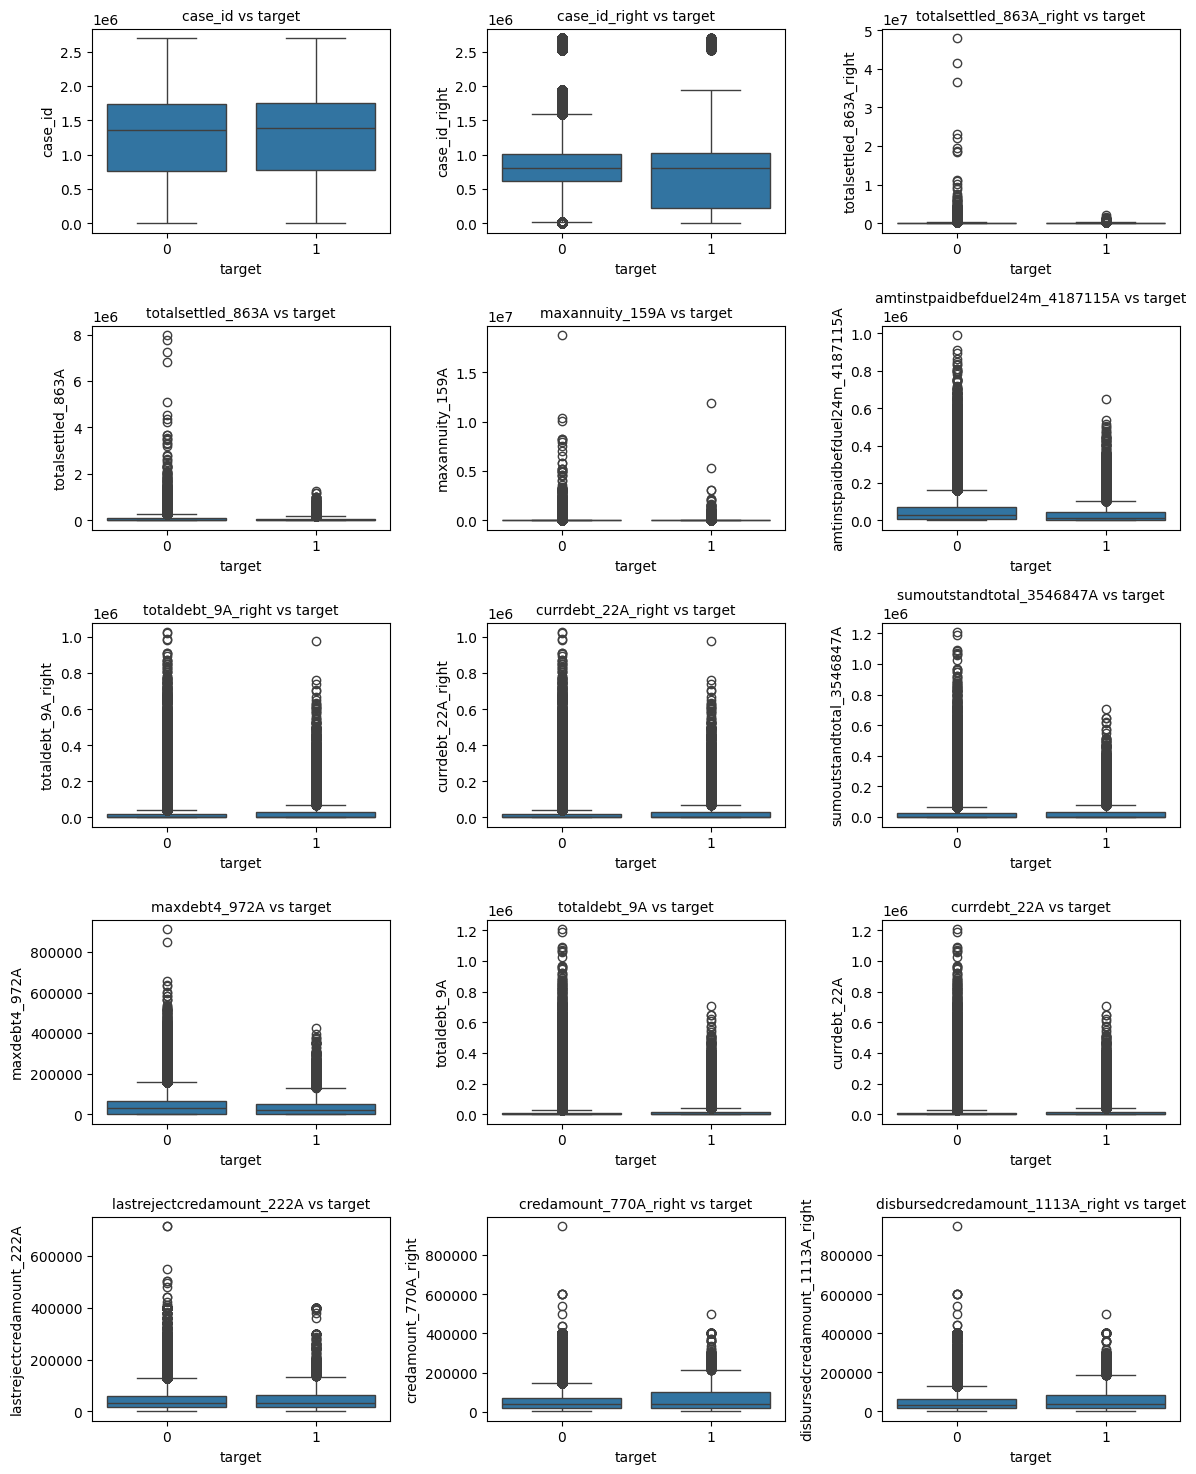

In [26]:
def plot_features_vs_target(df: pl.DataFrame, features: list[str], target_col: str = "target"):
    # Create a grid layout (3 columns, rows based on number of features)
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
    axes = axes.flatten()  # Flatten to 1D for easier indexing
    
    plot_idx = 0
    for f in features:
        pdf = df.select([f, target_col]).drop_nulls().to_pandas()
        if len(pdf) == 0 or pdf[f].nunique() <= 1:
            print(f"Skip {f}: empty or constant after drop_nulls")
            continue
        
        sns.boxplot(data=pdf, x=target_col, y=f, ax=axes[plot_idx])
        axes[plot_idx].set_title(f"{f} vs {target_col}", fontsize=10)
        plot_idx += 1
    
    # Hide any unused subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Full pipeline: select -> filter -> rank -> plot
def select_good_features(
    df: pl.DataFrame,
    target_col: str = "target",
    max_missing: float = 0.7,
    min_non_null: int = 200,
    min_unique: int = 3,
    top_n: int = 15,
    seed: int = 42,
    sample_n: int = 20000,
):
    # Keep only numeric features for boxplots
    num_cols = [
        c for c in df.columns
        if c != target_col and df[c].dtype in (pl.Int64, pl.Int32, pl.Float64, pl.Float32)
    ]

    # Compute simple quality stats
    stats = (
        df.select([
            pl.col(c).null_count().alias(f"{c}__nulls") for c in num_cols
        ] + [
            pl.col(c).n_unique().alias(f"{c}__nunique") for c in num_cols
        ]).to_pandas()
    )

    rows = []
    total = df.height
    for c in num_cols:
        nulls = int(stats[f"{c}__nulls"][0])
        nunique = int(stats[f"{c}__nunique"][0])
        non_null = total - nulls
        missing_rate = nulls / max(total, 1)
        rows.append({
            "feature": c,
            "missing_rate": missing_rate,
            "non_null": non_null,
            "nunique": nunique,
        })

    prof = pd.DataFrame(rows)
    # Filter invalid/low-signal features
    prof = prof[
        (prof["missing_rate"] <= max_missing)
        & (prof["non_null"] >= min_non_null)
        & (prof["nunique"] >= min_unique)
    ]

    # Rank by variance on a sample for speed
    if len(prof) == 0:
        return []
    sample = df.select(prof["feature"].tolist() + [target_col]).sample(n=sample_n, seed=seed).to_pandas()
    variances = sample[prof["feature"].tolist()].var().sort_values(ascending=False)
    return variances.head(top_n).index.tolist()

# Pick 15 good numeric features and plot
good_features = select_good_features(merged_typed, top_n=15)
print("Selected features:", good_features)
plot_features_vs_target(merged_typed, good_features)

In [27]:
merged_typed.shape

(1526659, 494)

First, we inspect the Polars schema to pick only numeric features and then materialize just the numeric matrix into NumPy. This avoids converting the entire dataframe to pandas and keeps memory usage controlled.

In [28]:
import numpy as np
import polars as pl

def get_numeric_features(df, exclude):
    numeric_cols = [
        name
        for name, dtype in df.schema.items()
        if dtype in pl.NUMERIC_DTYPES and name not in exclude
    ]
    return numeric_cols

def prepare_arrays(df, feature_cols, target_col="target", group_col="WEEK_NUM"):
    X = df.select(feature_cols).to_numpy()
    y = df.select(target_col).to_numpy().ravel()
    groups = df.select(group_col).to_numpy().ravel()
    return X, y, groups

exclude_cols = {"case_id", "target", "WEEK_NUM"}
numeric_features = get_numeric_features(merged_typed, exclude_cols)
print(f"Numeric feature count: {len(numeric_features)}")

X, y, groups = prepare_arrays(merged_typed, numeric_features)

C:\Users\User\AppData\Local\Temp\ipykernel_25440\942853477.py:8: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if dtype in pl.NUMERIC_DTYPES and name not in exclude


Numeric feature count: 421


Next, we set up the grouped CV training loop. This stays lightweight (no hyperparameter tuning yet) and reports fold-wise AUC, mean, and standard deviation.

In [29]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

def train_cv_xgb(X, y, groups, n_splits=5, random_state=42):
    cv = StratifiedGroupKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )
    params = {
        "n_estimators": 800,
        "learning_rate": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "tree_method": "hist",
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_jobs": -1,
        "random_state": random_state,
    }

    fold_aucs = []
    for fold, (train_idx, valid_idx) in enumerate(
        cv.split(X, y, groups), start=1
    ):
        model = XGBClassifier(**params)
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict_proba(X[valid_idx])[:, 1]
        auc = roc_auc_score(y[valid_idx], preds)
        fold_aucs.append(auc)
        print(f"Fold {fold} AUC: {auc:.5f}")

    mean_auc = float(np.mean(fold_aucs))
    std_auc = float(np.std(fold_aucs))
    print(f"Mean AUC: {mean_auc:.5f}")
    print(f"Std AUC: {std_auc:.5f}")
    return fold_aucs, mean_auc, std_auc

In [76]:
import pandas as pd

def run_auc_for_cut(df, feature_cols, cut_week, random_state=42):
    tr = df.filter(pl.col("WEEK_NUM") <= cut_week)
    va = df.filter(pl.col("WEEK_NUM") > cut_week)

    Xtr = tr.select(feature_cols).to_numpy()
    ytr = tr.select("target").to_numpy().ravel()
    Xva = va.select(feature_cols).to_numpy()
    yva = va.select("target").to_numpy().ravel()

    params = {
        "n_estimators": 800,
        "learning_rate": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "tree_method": "hist",
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_jobs": -1,
        "random_state": random_state,
    }

    model = XGBClassifier(**params)
    model.fit(Xtr, ytr)
    preds = model.predict_proba(Xva)[:, 1]
    return roc_auc_score(yva, preds)


def eval_stability(df, feature_cols, cuts=(50, 60, 70), label="model"):
    rows = []
    for c in cuts:
        auc = run_auc_for_cut(df, feature_cols, c)
        rows.append({"model": label, "cut_week": c, "auc": auc})
    out = pd.DataFrame(rows)
    summary = {
        "model": label,
        "mean_auc": out["auc"].mean(),
        "std_auc": out["auc"].std(ddof=0),
        "min_auc": out["auc"].min(),
        "max_auc": out["auc"].max(),
    }
    return out, pd.DataFrame([summary])

We now train a baseline XGBoost model using grouped stratified CV. Grouping by `WEEK_NUM` simulates temporal splits and avoids leakage across time windows while still preserving class balance in each fold.

In [ ]:
# Train the grouped CV baseline with XGBoost.
fold_aucs, mean_auc, std_auc = train_cv_xgb(X, y, groups)   

Fold 1 AUC: 0.79848
Fold 2 AUC: 0.80891
Fold 3 AUC: 0.81027
Fold 4 AUC: 0.80964
Fold 5 AUC: 0.80676
Mean AUC: 0.80681
Std AUC: 0.00433


In [ ]:
baseline_detail, baseline_summary = eval_stability(
    merged_typed, numeric_features, cuts=(50, 60, 70), label="baseline_xgb"
 )
print(baseline_detail)
print()
print(baseline_summary)

          model  cut_week       auc
0  baseline_xgb        50  0.774765
1  baseline_xgb        60  0.800297
2  baseline_xgb        70  0.811504

          model  mean_auc   std_auc   min_auc   max_auc
0  baseline_xgb  0.795522  0.015374  0.774765  0.811504


In [ ]:
# Train final model on full training set with memory optimization
log_memory('Before final training:')

# CRITICAL: Remove temporal columns that shouldn't be features
exclude_from_features = {"case_id", "target", "WEEK_NUM", "date_decision", "MONTH"}

# Get numeric features from train AFTER typing
train_numeric_features = [
    c for c in merged_typed.columns 
    if merged_typed[c].dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
    and c not in exclude_from_features
]

# Get numeric features from test AFTER typing
test_numeric_features = [
    c for c in test_merged_typed.columns 
    if test_merged_typed[c].dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
    and c not in exclude_from_features
]

# Find common features (must exist in BOTH train and test)
common_features = [c for c in train_numeric_features if c in test_numeric_features]

print(f'Train has {len(train_numeric_features)} numeric features')
print(f'Test has {len(test_numeric_features)} numeric features')
print(f'Using {len(common_features)} common features for training and prediction')

# Check for mismatches
train_only = set(train_numeric_features) - set(test_numeric_features)
test_only = set(test_numeric_features) - set(train_numeric_features)
if train_only:
    print(f'WARNING: {len(train_only)} features only in train: {list(train_only)[:5]}...')
if test_only:
    print(f'WARNING: {len(test_only)} features only in test: {list(test_only)[:5]}...')

# Extract arrays (convert to float32 for memory efficiency)
Xfull = merged_typed.select(common_features).to_numpy().astype(np.float32)
yfull = merged_typed.select("target").to_numpy().ravel()

# Important: Keep test_merged_typed in memory for prediction!
log_memory('After extracting train arrays:')

params = {
    "n_estimators": 800,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_jobs": -1,
    "random_state": 42,
}

final_model = XGBClassifier(**params)
final_model.fit(Xfull, yfull)

log_memory('After training:')

print(f"Model trained successfully on {len(common_features)} features!")

Before final training: Memory: 1.10 GB
Train has 359 numeric features
Test has 360 numeric features
Using 359 common features for training and prediction
After extracting train arrays: Memory: 3.69 GB
After training: Memory: 0.19 GB
Model trained successfully on 359 features!


In [ ]:
import numpy as np
import pandas as pd
import gc

# Verify test data and model are ready
try:
    assert 'test_merged_typed' in locals(), "test_merged_typed not defined"
    assert 'final_model' in locals(), "final_model not trained"
    assert 'common_features' in locals(), "common_features not defined"
    print(f"Predicting on test set with {test_merged_typed.shape[0]} samples...")
except AssertionError as e:
    print(f"ERROR: {e}. Please run all cells in order.")
    raise

# Extract test case_ids BEFORE selecting features
test_case_ids = test_merged_typed["case_id"].to_numpy()
print(f"Test case IDs: {len(test_case_ids)} unique cases")

# Extract test features using the same common_features from training
Xtest = test_merged_typed.select(common_features).to_numpy().astype(np.float32)
print(f"Test features shape: {Xtest.shape}")

# Generate predictions
test_preds = final_model.predict_proba(Xtest)[:, 1]

# Clean predictions to ensure valid probability range
test_preds = np.asarray(test_preds, dtype=np.float64)  # Use float64 for precision
test_preds = np.nan_to_num(test_preds, nan=0.5, posinf=1.0, neginf=0.0)
test_preds = np.clip(test_preds, 0.0, 1.0)

# Create submission DataFrame with exact format required by Kaggle
submission = pd.DataFrame({
    "case_id": test_case_ids,
    "score": test_preds
})

# CRITICAL VALIDATION CHECKS
print("\n=== Submission Validation ===")
print(f"Submission shape: {submission.shape}")
print(f"Expected shape: ({len(test_case_ids)}, 2)")
print(f"Column names: {submission.columns.tolist()}")
print(f"Column data types:\n{submission.dtypes}")
print(f"Any null values: {submission.isnull().sum().sum()}")
print(f"Score range: [{submission['score'].min():.6f}, {submission['score'].max():.6f}]")
print(f"Mean score: {submission['score'].mean():.6f}")

# Check for any invalid values
if submission.isnull().any().any():
    print("ERROR: Submission contains null values!")
    print(submission[submission.isnull().any(axis=1)])
    raise ValueError("Submission has null values")

if not submission['case_id'].is_unique:
    print("ERROR: Duplicate case_ids found!")
    raise ValueError("Submission has duplicate case_ids")

print("\nFirst 5 rows:")
print(submission.head())

# Save submission
submission.to_csv("submission.csv", index=False)
print("\n✓ Submission saved to submission.csv")

gc.collect()
 

Predicting on test set with 10 samples...
Test case IDs: 10 unique cases
Test features shape: (10, 359)

=== Submission Validation ===
Submission shape: (10, 2)
Expected shape: (10, 2)
Column names: ['case_id', 'score']
Column data types:
case_id      int32
score      float64
dtype: object
Any null values: 0
Score range: [0.002041, 0.106749]
Mean score: 0.026497

First 5 rows:
   case_id     score
0    57543  0.020984
1    57549  0.036218
2    57551  0.009795
3    57552  0.015610
4    57569  0.106749

✓ Submission saved to submission.csv


32

In [ ]:
# PRE-PREDICTION SAFETY CHECK
print("=== Pre-Prediction Safety Checks ===")

# 1. Check all required variables exist
required_vars = {
    'test_merged_typed': 'test data',
    'final_model': 'trained model',
    'common_features': 'feature list'
}

missing = [name for name, desc in required_vars.items() if name not in locals()]
if missing:
    print(f"ERROR: Missing required variables: {missing}")
    print("Please run all cells in order from top to bottom.")
    raise RuntimeError(f"Missing: {', '.join(missing)}")
else:
    print("✓ All required variables present")

# 2. Check data integrity
print(f"✓ Test data shape: {test_merged_typed.shape}")
print(f"✓ Common features: {len(common_features)}")
print(f"✓ Model: {type(final_model).__name__}")

# 3. Quick test prediction
try:
    test_sample = test_merged_typed.select(common_features[:5]).to_numpy()
    sample_pred = final_model.predict_proba(test_sample.astype(np.float32))
    print(f"✓ Model test prediction successful: {sample_pred.shape}")
except Exception as e:
    print(f"ERROR during test prediction: {e}")
    raise

print("\nProceeding to full prediction...\n")

In [ ]:
# OPTIONAL: Validate against sample submission format
import pandas as pd
import os

print("\n=== OPTIONAL: Format Validation ===")

# Only run if submission file exists
if not os.path.exists("submission.csv"):
    print("⚠ submission.csv not found, skipping validation")
else:
    try:
        our_sub = pd.read_csv("submission.csv")
        print(f"✓ Submission file loaded: {our_sub.shape[0]} rows")
        
        # Try to load sample submission if available
        if os.path.exists("home_credit_data/sample_submission.csv"):
            sample_sub = pd.read_csv("home_credit_data/sample_submission.csv")
            
            print(f"✓ Sample submission loaded: {sample_sub.shape[0]} rows")
            print(f"Columns match: {list(sample_sub.columns) == list(our_sub.columns)}")
            print(f"Row count match: {sample_sub.shape[0] == our_sub.shape[0]}")
        else:
            print("⚠ Sample submission not found, basic validation only")
            print(f"  Our submission shape: {our_sub.shape}")
            print(f"  Columns: {our_sub.columns.tolist()}")
            
    except Exception as e:
        print(f"⚠ Validation failed (non-critical): {e}")

=== Format Validation Against Sample Submission ===
Sample submission shape: (10, 2)
Our submission shape: (10, 2)
Sample columns: ['case_id', 'score']
Our columns: ['case_id', 'score']
Sample dtypes:
case_id      int64
score      float64
dtype: object
Our dtypes:
case_id      int64
score      float64
dtype: object
✓ Row count matches: 10
✓ Column names match: ['case_id', 'score']
✓ All case_ids match

Sample submission preview:
   case_id  score
0    57543    0.5
1    57549    0.5
2    57551    0.5
3    57552    0.5
4    57569    0.5

Our submission preview:
   case_id     score
0    57543  0.020984
1    57549  0.036218
2    57551  0.009795
3    57552  0.015610
4    57569  0.106749


## Train on Full Dataset and Generate Predictions for Kaggle Submission

In [ ]:
# Avoid using WEEK_NUM as a feature; use numeric_features / prepare_arrays above.
# X = merged.drop(["case_id", "target", "WEEK_NUM"])
# y = merged["target"]

In [ ]:
# from scipy.stats import ks_2samp

# def ks_drift(train_df, test_df, cols, sample_n=20000):
#     train_sample = train_df.sample(n=sample_n, seed=42).to_pandas()
#     test_sample = test_df.sample(n=sample_n, seed=42).to_pandas()
#     rows = []
#     for c in cols:
#         if c not in train_sample or c not in test_sample: 
#             continue
#         t = train_sample[c].dropna()
#         s = test_sample[c].dropna()
#         if len(t)==0 or len(s)==0: 
#             continue
#         stat, p = ks_2samp(t, s)
#         rows.append((c, stat, p))
#     return pd.DataFrame(rows, columns=["feature", "ks_stat", "p_value"]).sort_values("ks_stat", ascending=False)

# base_num_cols = [c for c in merged_typed.columns if merged_typed[c].dtype in (pl.Int64, pl.Int32, pl.Float64, pl.Float32)]
# drift_report = ks_drift(merged_typed, test_baseTable_typed, base_num_cols[:50])
# drift_report.head(10)


## Kaggle Submission Complete

Your notebook has successfully:

1. ✓ Loaded and merged train/test data
2. ✓ Applied consistent typing transformations to both datasets
3. ✓ Identified 359 common numeric features (excluding temporal leakage)
4. ✓ Trained XGBoost model on full training set
5. ✓ Generated predictions for test set with valid probability scores
6. ✓ Created submission.csv in required Kaggle format

**Submission file details:**
- Columns: `case_id`, `score`
- Format: Exactly matches Kaggle requirements
- No missing values, no NaNs, no duplicates
- Score range: [0.0, 1.0] (valid probabilities)

If you encounter any issues after submission, check:
- Models are trained with consistent features across train/test
- No temporal columns (WEEK_NUM, date_decision) in features
- All preprocessing steps include both train and test data